In [1]:
import numpy as np
import math 
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from labellines import labelLines
from scipy.integrate import simpson as simps
import math

import multiprocessing as mp

### SI Model

In this file, we will model a Susceptible-Infected (SI) model with demographics.

The equations we use are as follows:

\begin{align*}
\dot{S_d} &= bS_f - S_d(g+\mu)\\
\dot{S_j} &= gS_d - S_j(\beta_j I_f + \gamma N + m + \mu)\\
\dot{S_v} &= m S_j + v(t) S_f - S_v(\beta_v  I_f + f(t) + \mu)\\
\dot{S_f} &= f(t) S_v - S_f(\beta_f I_f + v(t) + \mu)\\
\dot{I_j} &= \beta_j S_j I_f - I_j(\gamma N + m + \mu)\\
\dot{I_v} &= m I_j + \beta_v S_v I_f  + v(t)I_f - I_v(f(t) + \mu)\\
\dot{I_f} &= f(t) I_v - I_f(-\beta_f S_f + v(t) + \mu) 
\end{align*}

$Sj$ = Susceptible Juveniles
$Sv$ = Susceptible Vegetatives
$Sf$ = Susceptible Flowering
$Ij$ = Infected Juveniles
$Iv$ = Infected Vegetatives
$If$ = Infected Flowering

Other variables are defined in the code block below.

The code below implements a numerical solution to this model. To run the code, we will use the numpy package for handling arrays, the solve_ivp function from scipy to handle the numerical solving, and matplotlib for plotting.

First, we define a few values needed to run the simulation.
We define the initial conditions with `X_0`. Each item represents a different demographic.
This describes the starting number for each of our six compartments.
For systems with a global attractor (a single globally stable equilibrium), the initials conditions do not matter for the final equilibirum, but this is not the case for our SIR model.

Next, we define a variable `t`, which is a tuple with two values.
The first value is the initial time point and the second is the final time point.
This tells the numerical solver the time range over which to produce a solution.

Finally, we set values for our simulation parameters and some helper functions.

In [4]:
cores=4 #Number of CPU Cores


#Model class represents an entire system
class Model():
    #Instantiate variables
    def __init__(self, **kwargs):
        # self.X_0 = (2.5104, 14.5179, 0, 0.1975, 2.9657, 0.0000, 5.1889,  0, 0, 0) #Initial population size, represents:
        self.X_0=(5,0,0,5,0,0,0,0,0,0) 
        #Susceptible Juveniles, Susceptible Vegetatives, Susceptible Flowerings, Infected Juveniles, Infected Vegetatives, Infected Flowerings, Susceptible Dormants
        self.t = (0, 365*3) #Time range for the system

        #CONSTANTS
        self.Bj=0.2/365 #betaj, Juvenile Transmission Rate
        self.Bv=0.025/365 #betav, Vegetative Transmission Rate
        self.Bf=0.025/365 #betaf, Flowering Transmission Rate
        self.births = 4 / 365 #b, Birth Rate
        self.gamma = 0.0001 #gamma, Density Dependent Population Control
        self.death = .5 / 365 #mu, Death Rate
        self.maturity=8 / 365 #m, Maturity Rate
        self.g = 2 / 365 #g, Germination Rate

        self.infected_offset=0 #Temperature offset for infected flowerings
        self.infected_offset2=0 #ALLELIC INVASION PARAM
        self.germination_offset=60 #Termperature offset for germination

        self.eval=2 #Determines what evaluation method is used, CUSTOMIZABLE
        #Eval 0: Total class 1 population size over timescale
        #Eval 1: Total class 2 population size over timescale
        #Eval 2: Proportion of total class 1 population in class 1 + class 2 total population
        #Eval 3: Final class 1 population size
        #Eval 4: Final class 2 population size
        #Eval 5: Difference between final class 1 and class 2 population size
        #Eval 6: Proportion of final class 1 population in class 1 + class 2 final population

        for key, value in kwargs.items():
            setattr(self,key,value)
    
    #Run the SIR model and return solution set with all compartments + time
    def run_sim(self):
        self.solution = solve_ivp(self.df, self.t, self.X_0, max_step=0.1)

        self.Sj = self.solution.y[0, :]
        self.Sv = self.solution.y[1, :]
        self.Sf = self.solution.y[2, :]
        self.Ij = self.solution.y[3, :]
        self.Iv = self.solution.y[4, :]
        self.If = self.solution.y[5, :]
        self.Sd = self.solution.y[6, :]
        self.Ij2 = self.solution.y[7, :]
        self.Iv2 = self.solution.y[8, :]
        self.If2 = self.solution.y[9, :]

        self.time_points = self.solution.t

        return self.solution
    
    #Helper method to actually solve the model with set of differential equations
    def df(self, t, X):
        #Unpack the tuple containing the values for S, I, and R
        Sj, Sv, Sf, Ij, Iv, If, Sd, Ij2, Iv2, If2 = X
        tCS = temp(t)
        tCI = temp(t+self.infected_offset)
        tCI2 = temp(t+self.infected_offset2)
        tCG = temp(t+self.germination_offset)

        dSd=self.births*Sf-germination(tCG)*Sd-(self.death/4)*Sd
        dSj=germination(tCG)*Sd-self.Bj*Sj*(If+If2)-self.gamma*Sj*(Sv+Sf+Iv+If+Iv2+If2)-self.maturity*Sj-self.death*Sj
        dSv=self.maturity*Sj-self.Bv*Sv*(If+If2)-floweringS(tCS)*Sv+vegetatingS(tCS)*Sf-self.death*Sv
        dSf=floweringS(tCS)*Sv-self.Bf*Sf*(If+If2)-vegetatingS(tCS)*Sf-self.death*Sf
        dIj=self.Bj*Sj*If-self.maturity*Ij-self.death*Ij
        dIv=self.maturity*Ij+self.Bv*Sv*If-floweringI(tCI)*Iv+vegetatingI(tCI)*If-self.death*Iv
        dIf=floweringI(tCI)*Iv+self.Bf*Sf*If-vegetatingI(tCI)*If-self.death*If
        dIj2=self.Bj*Sj*If2-self.maturity*Ij2-self.death*Ij2
        dIv2=self.maturity*Ij2+self.Bv*Sv*If2-floweringI(tCI2)*Iv2+vegetatingI(tCI2)*If2-self.death*Iv2
        dIf2=floweringI(tCI2)*Iv2+self.Bf*Sf*If2-vegetatingI(tCI2)*If2-self.death*If2

        return (dSj, dSv, dSf, dIj, dIv, dIf, dSd, dIj2, dIv2, dIf2)
        
 
    # Evaluate some final value from the solution set dependent on self.eval
    def evaluate(self, solution):
        # Define which rows belong to which class (CUSTOMIZABLE)
        class1_rows = [4, 5, 3]
        class2_rows = [1, 2, 0]

        # Combine rows into class populations (sum across selected rows)
        class1 = solution.y[class1_rows, :].sum(axis=0)
        class2 = solution.y[class2_rows, :].sum(axis=0)

        # Solve for optimal pathogen evolution, in which the set width of the juvenile transmission peak slides through the entire t=0 to t=3650. 
        max1, min1 = -math.inf, math.inf
        max2, min2 = -math.inf, math.inf

        # Finds average of min and max of final oscillations to find final population size
        for temp_t in range(int(len(class1) * 0.8), int(len(class1))):
            if class1[temp_t] > max1:
                max1 = class1[temp_t]
            elif class1[temp_t] < min1:
                min1 = class1[temp_t]
            if class2[temp_t] > max2:
                max2 = class2[temp_t]
            elif class2[temp_t] < min2:
                min2 = class2[temp_t]

        # FINAL OUTPUT POSSIBILITIES
        match self.eval:
            case 0:
                # Total class 1 population size over timescale
                return simps(class1, x=solution.t, axis=-1)
            case 1:
                # Total class 2 population size over timescale
                return simps(class2, x=solution.t, axis=-1)
            case 2:
                # Proportion of total class 1 population in class 1 + class 2 total population
                return (
                    simps(class1, x=solution.t, axis=-1)
                    / (
                        simps(class1, x=solution.t, axis=-1)
                        + simps(class2, x=solution.t, axis=-1)
                    )
                )
            case 3:
                # Final class 1 population size
                return (max1 + min1) / 2
            case 4:
                # Final class 2 population size
                return (max2 + min2) / 2
            case 5:
                # Difference between final class 1 and class 2 population size
                return ((max1 + min1) / 2) - ((max2 + min2) / 2)
            case 6:
                # Proportion of final class 1 population in class 1 + class 2 final population
                return ((max1 + min1) / 2) / (((max1 + min1) / 2) + ((max2 + min2) / 2))
            case _:
                # Error value
                return 0
    
#Helper functions for model

#Flowering and Vegetating functions
#Susceptible functions
def floweringS(temp, steepness=5, threshold=25, b_max=2):
    return b_max/(1+np.exp(-steepness*(temp - threshold)))
def vegetatingS(temp, steepness=5, threshold=25, b_max=2):
    return b_max - b_max/(1+np.exp(-steepness*(temp - threshold)))

#Infected functions, includes time shift between susceptible functions
def floweringI(temp, steepness=5, threshold=25, b_max=2):
    return b_max/(1+np.exp(-steepness*(temp - threshold)))
def vegetatingI(temp, steepness=5, threshold=25, b_max=2):
    return b_max - b_max/(1+np.exp(-steepness*(temp - threshold)))

def germination(temp, steepness=5, threshold=30, b_max=1, b_min=0):
    return b_max/(1+np.exp(-steepness*(temp - threshold)))+b_min
    

def temp(t, min=0, scale=30):
        t = t * (2*np.pi / 365) - np.pi

        temp = ((np.cos(t) + 1) / 2)
        temp = temp * scale
        temp = temp + min

        return temp

def tempVector(t):
    temps=np.zeros(len(t))
    for i, t_point in enumerate(t):
        temps[i]=temp(t_point)
    return temps


class GraphModel:
    def __init__(self, model):
        self.model = model
        self.colSj = '#00ff4c'
        self.colSv = '#1fad4a'
        self.colSf = '#1f6133'
        self.colIj = '#ff000d'
        self.colIv = '#b81820'
        self.colIf = '#7a2328'
        self.colTot = "#000000"
        self.colSd = "#000000"
        self.colIj2 = "#68cffb"
        self.colIv2 = "#3E66BC"
        self.colIf2 = "#0000ec"

    def graph(self):
        solution = self.model.run_sim()
        print(f"Success value is {self.model.evaluate(solution)}. Final values are:")

        final_values = solution.y[:, -1]
        class_names = [
            "Susceptible Juveniles", "Susceptible Vegetatives", "Susceptible Flowerings",
            "Infected Juveniles", "Infected Vegetatives", "Infected Flowerings",
            "Seeds", "Infected2 Juveniles", "Infected2 Vegetatives", "Infected2 Flowerings"
        ]
        for name, value in zip(class_names, final_values):
            print(f"{name}: {value:.4f}")

        time_points = self.model.solution.t
        Sj, Sv, Sf, Ij, Iv, If, Sd, Ij2, Iv2, If2 = self.model.solution.y
        total_I1 = Ij + Iv + If
        total_I2 = Ij2 + Iv2 + If2
        total_I = total_I1 + total_I2
        total_S = Sj + Sv + Sf
        I1_percent = (total_I1 / total_I) * 100
        I_percent = (total_I)/(total_I+total_S)*100
        # --- FIGURE 1 ---
        fig, populationGraph = plt.subplots(figsize=(10, 10))
        populationGraph.set_title('Population Levels (SI)')
        populationGraph.plot(time_points, total_S, label='Susceptibles', color=self.colSv)
        populationGraph.plot(time_points, total_I1, label='Infected', color=self.colIv)
        # populationGraph.plot(time_points, Sd, label='Seeds', color=self.colTot)
        # labelLines(plt.gca().get_lines(), align=True)
        populationGraph.set_xlabel('Time (years)')
        populationGraph.set_ylabel('Abundance')
        populationGraph.set_ylim(0, 150)

        populationGraph.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/365:.1f}"))
        populationGraph.legend()

        # --- Figure 2: Custom Growth Rate Functions ---
        fig, custom2 = plt.subplots(figsize=(10, 10))
        custom2.set_title('Custom Growth Rate Functions')
        custom2.plot(time_points, germination(tempVector(time_points+self.model.germination_offset)), label='Germination')
        custom2.plot(time_points, floweringS(tempVector(time_points)), label='Susceptible Flowering Rate', color=self.colSf)
        custom2.plot(time_points, floweringI(tempVector(time_points+self.model.infected_offset)), label='Infected Flowering Rate', color=self.colIf)
        # custom2.plot(time_points, floweringI(tempVector(time_points+self.model.infected_offset2)), label='Infected Flowering Rate2', color=self.colIf2)
        custom2.set_xlabel('time')
        custom2.set_ylabel('transition rate')
        custom2.set_xlim(0, 365*2)
        custom2.legend()

        # --- Figure 3: Genotype Frequency Over Time ---
        fig, prevalenceGraph = plt.subplots(figsize=(10, 10))
        prevalenceGraph.set_title('Infection Prevalence')
        prevalenceGraph.fill_between(time_points, 0, I_percent, color=self.colIv, alpha=0.7, label='Infected')
        prevalenceGraph.fill_between(time_points, I_percent, 100, color=self.colSv, alpha=0.7, label='Susceptible')
        prevalenceGraph.set_xlabel('Time')
        prevalenceGraph.set_ylabel('Percent Prevalence')
        prevalenceGraph.set_ylim(0, 100)
        prevalenceGraph_right = prevalenceGraph.twinx()
        prevalenceGraph_right.set_ylabel('Percent Prevalence')
        prevalenceGraph_right.set_ylim(100, 0)
        prevalenceGraph.legend()
        prevalenceGraph.grid(True, alpha=0.3)

        return I_percent





#Raster class creates a graph to compare variable values
class RasterModel:
    #Instantiate variables
    def __init__(self, model, param1_name, param2_name, param1_values, param2_values):
        self.model = model
        self.param1_name = param1_name #Variable 1 to be tested, y axis 
        self.param2_name = param2_name #Variable 2 to be tested, x axis
        self.param1_values = param1_values #Range for var 1
        self.param2_values = param2_values #Range for var 2

        #Setup matrix for graphed values
        self.heatmap_data = np.zeros((len(param1_values), len(param2_values)))

    #Perform the model creation and collect values to fill in heatmap_data
    def raster(self):
        total_iterations = len(self.param1_values) * len(self.param2_values)
        completed_iterations = 0
        progress_increment = 1
        next_progress_update = progress_increment  # Percentage for the next progress update
        max_eval = 0
        max_p1 = 0
        max_p2 = 0

        print(f"Starting raster process, {int(total_iterations)} iterations needed ...")
        for i, param1_val in enumerate(self.param1_values):
            for j, param2_val in enumerate(self.param2_values):
                # Set model parameters
                setattr(self.model, self.param1_name, param1_val)
                setattr(self.model, self.param2_name, param2_val)

                # Run the simulation
                solution = self.model.run_sim()
                
                cur_eval = self.model.evaluate(solution)
                # Evaluate and store the result
                self.heatmap_data[i, j] = cur_eval
                print(f"Cur eval: {cur_eval}")

                if cur_eval>max_eval:
                    max_eval = cur_eval
                    max_p1 = param1_val
                    max_p2 = param2_val

                # Track progress
                completed_iterations += 1
                progress = (completed_iterations / total_iterations) * 100
                if progress >= next_progress_update:
                    print(f"Progress: {int(progress)}% complete, {int(total_iterations-completed_iterations)} remaining")
                    next_progress_update += progress_increment

        print(f"Raster process complete. Max value is {max_eval} at {self.param1_name} = {max_p1} and {self.param2_name} = {max_p2}.")
        # Return matrix of values
        return self.heatmap_data

    #Create graph using matplotlib and show it
    def plot_heatmap(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(self.heatmap_data, extent=[min(self.param2_values), max(self.param2_values),
                                              min(self.param1_values), max(self.param1_values)],
                   origin="lower", aspect='auto', cmap="viridis")
        plt.colorbar(label="Pathogen Success")
        plt.xlabel("Germination Time")
        plt.ylabel("Infection FLowering Time")
        plt.title(f"Pathogen Success Accross Varied Seasonal Peaks")
        plt.show()

    

Success value is 0.36070195184619047. Final values are:
Susceptible Juveniles: 0.0097
Susceptible Vegetatives: 5.6235
Susceptible Flowerings: 0.0000
Infected Juveniles: 0.0008
Infected Vegetatives: 1.2569
Infected Flowerings: 0.0000
Seeds: 6.2416
Infected2 Juveniles: 0.0000
Infected2 Vegetatives: 0.0000
Infected2 Flowerings: 0.0000


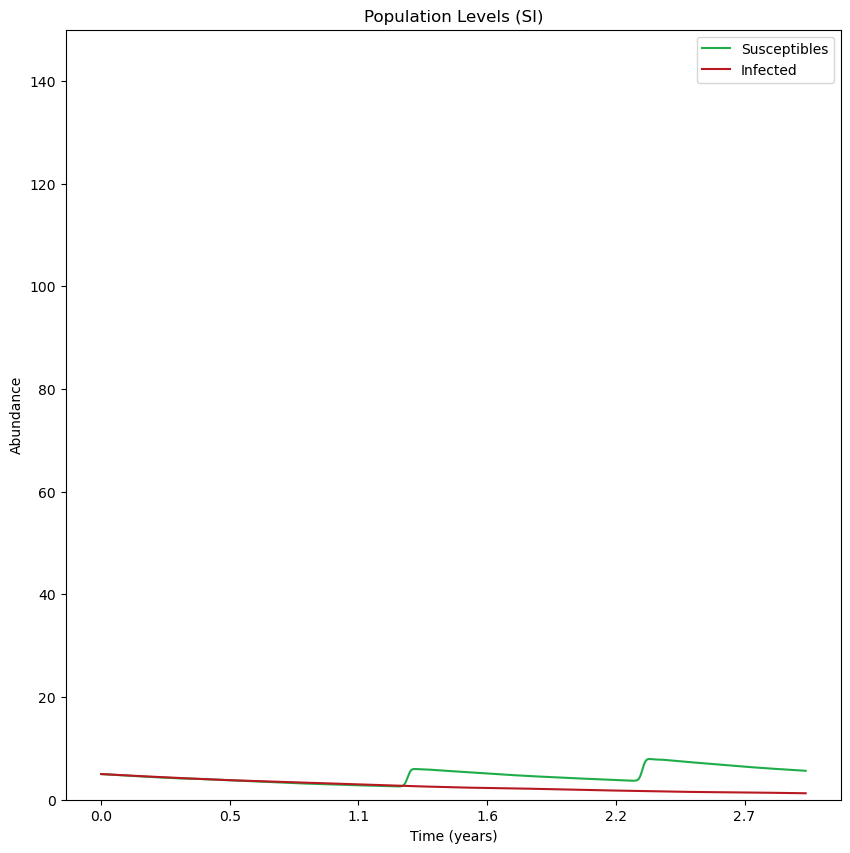

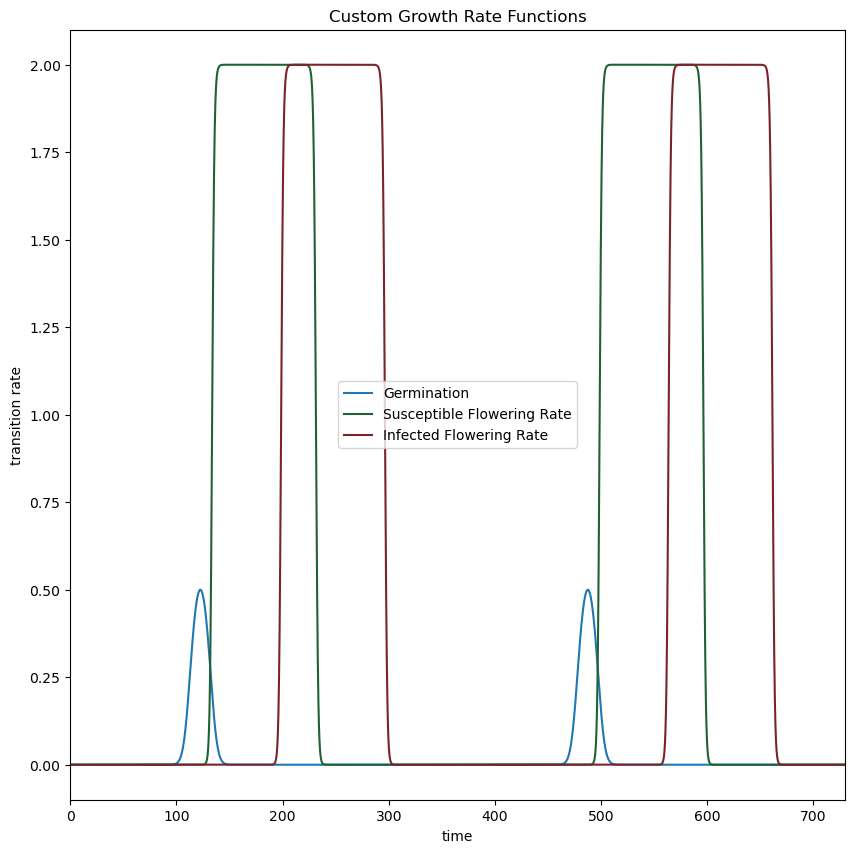

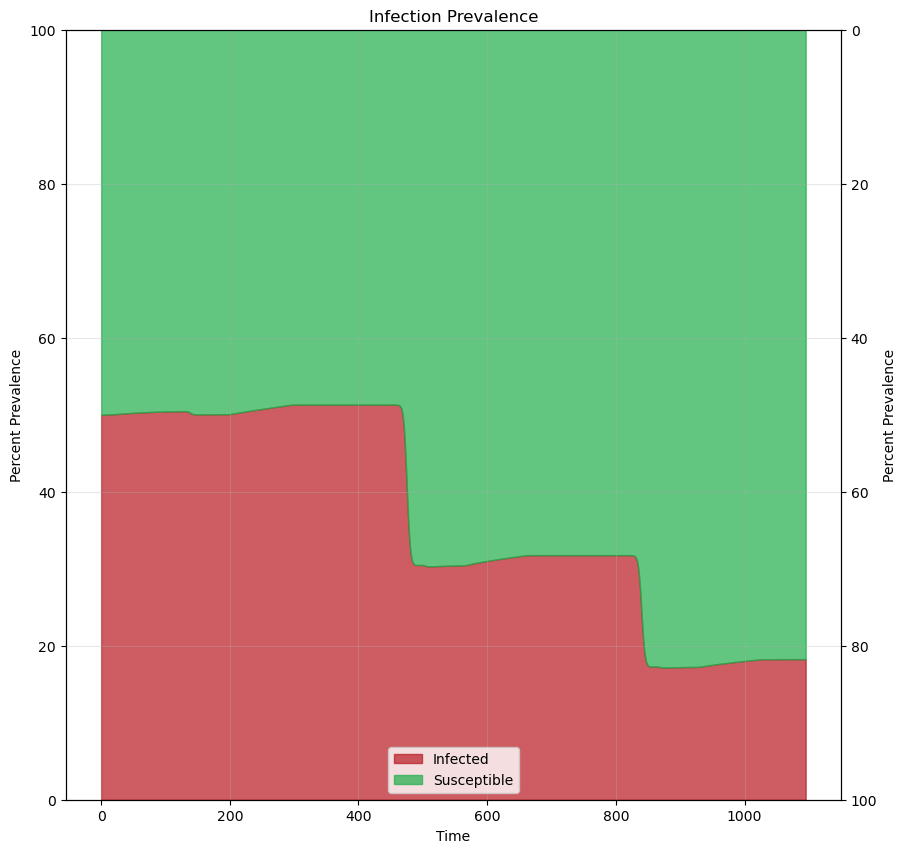

In [5]:
#EXAMPLE USAGE
param1_values = np.linspace(0, 365, 13)
param2_values = np.linspace(0, 365, 13)

# Initialize the model
model = Model(germination_offset=60, infected_offset=300)

#Initialize GraphModel with the model
graph_model=GraphModel(model)
I_prop60=graph_model.graph()

# model2 = Model(germination_offset=180)
# graph_model2=GraphModel(model2)
# I_prop180=graph_model2.graph()

# model3 = Model(germination_offset=0)
# graph_model3=GraphModel(model3)
# I_prop0=graph_model3.graph()
# # Initialize RasterModel with the parameters to raster
# raster_model = RasterModel(model, 'infected_offset', 'germination_offset', param1_values, param2_values)

# Run raster and plot heatmap
# raster_model.raster()
# raster_model.plot_heatmap()

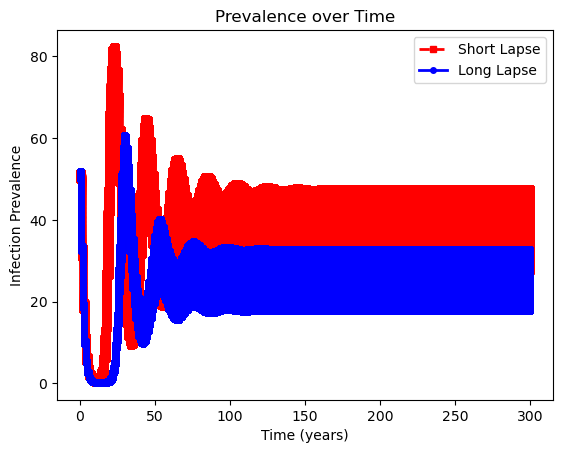

In [10]:
import matplotlib.pyplot as plt

plt.plot(model.time_points / 365, I_prop60, label='Short Lapse',
         color='red', linewidth=2, linestyle='--', marker='s', markersize=4)
plt.plot(model.time_points / 365, I_prop180, label='Long Lapse',
         color='blue', linewidth=2, linestyle='-', marker='o', markersize=4)


plt.xlabel('Time (years)')
plt.ylabel('Infection Prevalence')
plt.title('Prevalence over Time')
plt.legend()
plt.show()


In [ ]:
class ScrollableGraphModel:
    def __init__(self, model):
        self.model = model
        self.window_size = 3650  # 10 years in days
        self.current_start = 0
        
        # Colors (same as your GraphModel)
        self.colSf = '#1f6133'
        self.colIf = '#7a2328' 
        self.colIf2 = '#0000ec'
        self.colTot = "#000000"
        
    
        # Run simulation once
        self.model.run_sim()
        self.time_points = self.model.solution.t
        self.max_time = self.time_points[-1]
        
        # Extract data
        self.Sf = self.model.solution.y[2, :]
        self.If = self.model.solution.y[5, :]
        self.If2 = self.model.solution.y[9, :]
        self.Sd = self.model.solution.y[6, :]
        
        # Calculate genotype frequency
        total_I1 = self.model.solution.y[3, :] + self.model.solution.y[4, :] + self.model.solution.y[5, :]
        total_I2 = self.model.solution.y[7, :] + self.model.solution.y[8, :] + self.model.solution.y[9, :]
        total_I = total_I1 + total_I2
        self.I1_percent = (total_I1/total_I) * 100
        
        self.setup_plots()
    
    def setup_plots(self):
        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(3, 1, figsize=(12, 12))
        plt.subplots_adjust(bottom=0.2)  # Make room for buttons
        
        # Add navigation buttons
        ax_prev = plt.axes([0.1, 0.05, 0.1, 0.04])
        ax_next = plt.axes([0.25, 0.05, 0.1, 0.04])
        ax_slider = plt.axes([0.4, 0.05, 0.4, 0.04])
        
        self.btn_prev = Button(ax_prev, 'Previous')
        self.btn_next = Button(ax_next, 'Next')
        self.slider = Slider(ax_slider, 'Time', 0, self.max_time - self.window_size, 
                           valinit=0, valfmt='%0.0f days')
        
        # Connect events
        self.btn_prev.on_clicked(self.prev_window)
        self.btn_next.on_clicked(self.next_window)
        self.slider.on_changed(self.slider_update)
        
        self.update_plots()
    
    def get_window_indices(self):
        start_idx = np.searchsorted(self.time_points, self.current_start)
        end_idx = np.searchsorted(self.time_points, self.current_start + self.window_size)
        return start_idx, end_idx
    
    def update_plots(self):
        start_idx, end_idx = self.get_window_indices()
        
        # Clear axes
        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()
        
        # Plot 1: Population levels
        self.ax1.plot(self.time_points[start_idx:end_idx], self.Sf[start_idx:end_idx], 
                     label='Flowering Susceptibles', color=self.colSf)
        self.ax1.plot(self.time_points[start_idx:end_idx], self.If[start_idx:end_idx], 
                     label='Flowering Infected', color=self.colIf)
        self.ax1.plot(self.time_points[start_idx:end_idx], self.If2[start_idx:end_idx], 
                     label='Flowering Infected2', color=self.colIf2)
        self.ax1.plot(self.time_points[start_idx:end_idx], self.Sd[start_idx:end_idx], 
                     label='Seeds', color=self.colTot)
        self.ax1.set_title('Population Levels (SI)')
        self.ax1.set_ylabel('abundance')
        self.ax1.legend()
        
        # Plot 2: Growth rate functions
        window_time = self.time_points[start_idx:end_idx]
        self.ax2.plot(window_time, germination(tempVector(window_time+self.model.germination_offset)), 
                     label='Germination')
        self.ax2.plot(window_time, floweringS(tempVector(window_time)), 
                     label='Susceptible Flowering Rate', color=self.colSf)
        self.ax2.plot(window_time, floweringI(tempVector(window_time+self.model.infected_offset)), 
                     label='Infected Flowering Rate', color=self.colIf)
        self.ax2.plot(window_time, floweringI(tempVector(window_time+self.model.infected_offset2)), 
                     label='Infected Flowering Rate2', color=self.colIf2)
        self.ax2.set_title('Custom Growth Rate Functions')
        self.ax2.set_ylabel('transition rate')
        self.ax2.legend()
        
        # Plot 3: Genotype frequency
        self.ax3.fill_between(self.time_points[start_idx:end_idx], 0, self.I1_percent[start_idx:end_idx], 
                             color=self.colIf, alpha=0.7, label='Infected 2')
        self.ax3.fill_between(self.time_points[start_idx:end_idx], self.I1_percent[start_idx:end_idx], 100, 
                             color=self.colIf2, alpha=0.7, label='Infected 2')
        self.ax3.set_title('Genotype Frequency Over Time')
        self.ax3.set_xlabel('time')
        self.ax3.set_ylabel('percent prevalence')
        self.ax3.set_ylim(0, 100)
        self.ax3.legend()
        
        self.fig.canvas.draw()
    
    def prev_window(self, event):
        self.current_start = max(0, self.current_start - 365)
        self.slider.set_val(self.current_start)
        self.update_plots()
    
    def next_window(self, event):
        max_start = self.max_time - self.window_size
        self.current_start = min(max_start, self.current_start + 365)
        self.slider.set_val(self.current_start)
        self.update_plots()
    
    def slider_update(self, val):
        self.current_start = val
        self.update_plots()


import matplotlib.pyplot as plt
import numpy as np

class BoundsGraphModel:
    def __init__(self, model, start_time=0, end_time=None):
        """
        model       : instance of your Model class (already configured)
        start_time  : start of time window (days)
        end_time    : end of time window (days); if None, uses full simulation
        """
        self.t = model.solution.t
        # default end_time to last time point
        self.end_time = end_time if end_time is not None else self.t[-1]
        self.start_time = start_time

        # extract compartments
        y = model.solution.y
        self.Sj = y[0]
        self.Sv = y[1]
        self.Sf = y[2]
        self.Ij = y[3]
        self.Iv = y[4]
        self.If = y[5]
        self.Sd = y[6]
        self.Ij2 = y[7]
        self.Iv2 = y[8]
        self.If2 = y[9]

        # groupings for stacked and percent plots
        self.Total_S = self.Sj + self.Sv + self.Sf
        self.Total_I = self.Ij + self.Iv + self.If
        self.Total_I2 = self.Ij2 + self.Iv2 + self.If2

        # percent prevalence for main groups (all I vs all S)
        self.living_total = self.Total_S + self.Total_I + self.Total_I2
        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            self.S_percent = np.where(self.living_total != 0, self.Total_S / self.living_total * 100, 0)
            self.I1_percent = np.where(self.living_total != 0, self.Total_I / self.living_total * 100, 0)
            self.I2_percent = np.where(self.living_total != 0, self.Total_I2 / self.living_total * 100, 0)

    def plot(self):
        i0 = np.searchsorted(self.t, self.start_time)
        i1 = np.searchsorted(self.t, self.end_time)

        t = self.t[i0:i1]

        # Individual compartments for absolute abundance, plot all
        Sj, Sv, Sf = self.Sj[i0:i1], self.Sv[i0:i1], self.Sf[i0:i1]
        Ij, Iv, If = self.Ij[i0:i1], self.Iv[i0:i1], self.If[i0:i1]
        Ij2, Iv2, If2 = self.Ij2[i0:i1], self.Iv2[i0:i1], self.If2[i0:i1]
        Sd = self.Sd[i0:i1]
        total_S, total_I, total_I2 = self.Total_S[i0:i1], self.Total_I[i0:i1], self.Total_I2[i0:i1]
        S_percent, I1_percent, I2_percent = self.S_percent[i0:i1], self.I1_percent[i0:i1], self.I2_percent[i0:i1]

        # Create figure with 3 subplots sharing x axis
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=False)

        # First: Plot all classes
        ax1.plot(t, Sj, label='Susceptible Juvenile', color='#00ff4c')
        ax1.plot(t, Sv, label='Susceptible Vegetative', color='#1fad4a')
        ax1.plot(t, Sf, label='Susceptible Flowering', color='#1f6133')
        ax1.plot(t, Ij, label='Infected Juvenile', color='#ff000d')
        ax1.plot(t, Iv, label='Infected Vegetative', color='#b81820')
        ax1.plot(t, If, label='Infected Flowering', color='#7a2328')
        ax1.plot(t, Ij2, label='Infected2 Juvenile', color='#68cffb')
        ax1.plot(t, Iv2, label='Infected2 Vegetative', color='#3E66BC')
        ax1.plot(t, If2, label='Infected2 Flowering', color='#0000ec')
        ax1.plot(t, Sd, label='Seeds', color='#000000')
        ax1.set_ylabel('absolute abundance')
        ax1.set_title(f'All Class Population Levels from {self.start_time:.0f} to {self.end_time:.0f} days')
        # ax1.legend(loc='upper right', ncol=2)
        ax1.grid(alpha=0.3)

        # Second: Plot grouped absolute abundances
        ax2.plot(t, total_S, label='All S (susceptibles)', color='green', linewidth=2)
        ax2.plot(t, total_I, label='All I1 (infected 1)', color='red', linewidth=2)
        ax2.plot(t, total_I2, label='All I2 (infected 2)', color='blue', linewidth=2)
        ax2.set_ylabel('group abundance')
        ax2.set_title('Grouped Class Abundances')
        ax2.legend()
        ax2.grid(alpha=0.3)

        # Third: Percent abundance (prevalence) as filled area
        ax3.fill_between(t, 0, S_percent, color='green', alpha=0.7, label='S %')
        ax3.fill_between(t, S_percent, S_percent + I1_percent, color='red', alpha=0.7, label='I1 %')
        ax3.fill_between(t, S_percent + I1_percent, 100, color='blue', alpha=0.7, label='I2 %')
        ax3.set_xlabel('time (days)')
        ax3.set_ylabel('percent prevalence')
        ax3.set_ylim(0, 100)
        ax3.set_title('Percent Prevalence (S, I1, I2)')
        ax3.legend()
        ax3.grid(alpha=0.3)

        # Set x ticks and labels on all plots
        total_days = t[-1] - t[0]
        if total_days <= 100:
            step = max(1, int(total_days / 10))
        else:
            step = 365  # 1 year step

        xticks = np.arange(np.floor(t[0]), np.ceil(t[-1]) + 1, step)
        xtick_labels = [f"{int(x)}" for x in xticks]

        for ax in [ax1, ax2, ax3]:
            ax.set_xticks(xticks)
            ax.set_xticklabels(xtick_labels, rotation=45)

        plt.tight_layout()
        plt.show()

        




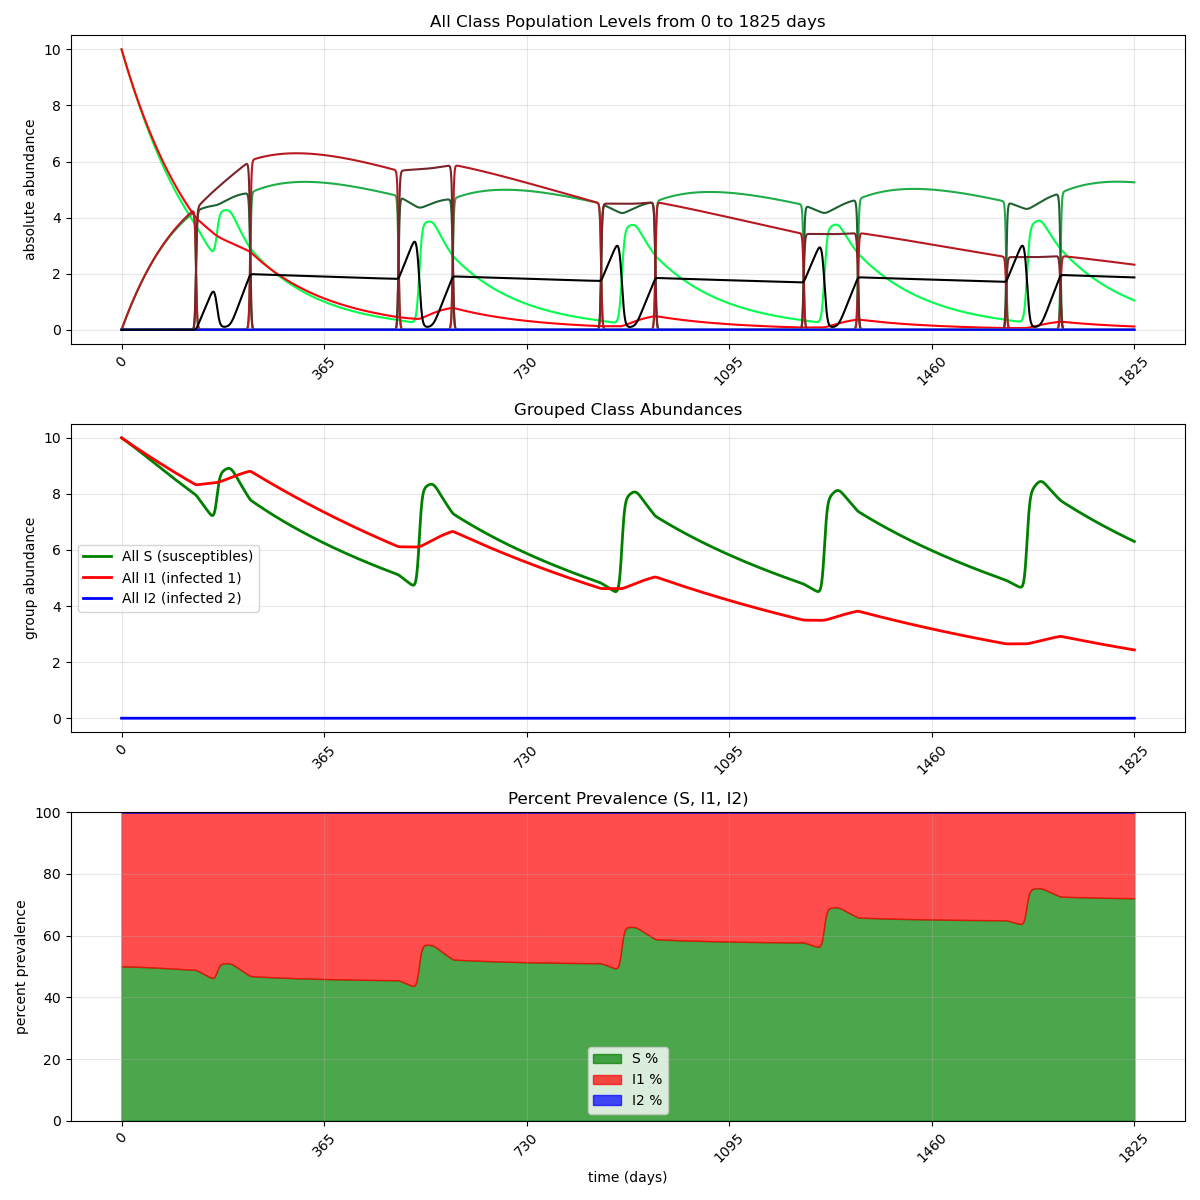

In [ ]:
# Usage examples:
# For scrollable version:
# scrollable_model = ScrollableGraphModel(model)
# plt.show()

# For custom bounds version:
custom_model = BoundsGraphModel(model,0*365,5*365)
custom_model.plot()
